# Train Low Test Models

This notebook is a streamlined notebook for generating minima of low test accuracy through three different means:
- Dataset Poisoning
- Adding Noise to Data
- Decreasing Dataset Sizes

## Imports

In [1]:
# Standard library
import copy
import os
import sys
import time

# Third-party
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Local package imports
from minima_volume.dataset_funcs import (
    prepare_datasets,
    save_dataset,
    save_model,
)
from minima_volume.train_funcs import evaluate, train

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Input Parameters

In [2]:

# ==============================
# Base Input Parameters
# ==============================
# --- SEEDS ---
data_seed = 8            
model_seed = 8           

# --- Training configuration ---
epochs = 2000            

# --- Dataset configuration ---
base_data_size = 400      
dataset_type = "poison"    
dataset_quantities = [0, 10, 20, 50, 100]

# --- Output configuration ---
base_output_dir = ""     
save_generated_dataset = True   
save_generated_models = True    


## Model + Dataset Specific Code

This is for specific code.

In [3]:
# User specifies the model module name
from minima_volume.models import swiss_model_data as model_module

test_dataset_size = 2000

# Generate dataset
x_base, y_base, x_test, y_test = model_module.get_dataset(
    base_data_size=base_data_size,
    dataset_quantities=dataset_quantities,
    test_dataset_size=test_dataset_size,
    noise=0.3, # default swiss params
    extra_pts=1000,
    dataset_type=dataset_type,
    seed=data_seed
)

# Swiss specific initialization parameters
input_dim = 2
output_dim = 1
hidden_dims = [32]*5

# Grab model
model_template = model_module.get_model(input_dim=input_dim, hidden_dims=hidden_dims, output_dim=output_dim, device=device, seed=model_seed)

# Grab loss and metrics
loss_fn = model_module.get_loss_fn()
other_metrics = model_module.get_additional_metrics()

## Training

We generate the various datasets used to train our models here, before training them. We record the losses, and what each model was trained on.

In [4]:
# ==============================
# Prepare datasets
# ==============================
x_base_train, y_base_train, x_additional, y_additional = prepare_datasets(
    x_base=x_base,
    y_base=y_base,
    dataset_type=dataset_type,
    dataset_quantities=dataset_quantities,
    base_data_size=base_data_size,
    data_seed=data_seed,
    seed_1=None,
    seed_2=None,
)

x_base_train = x_base_train.to(device)
y_base_train = y_base_train.to(device)
x_additional = x_additional.to(device)
y_additional = y_additional.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)

# ==============================
# Training loop
# ==============================
all_models = []

for additional_data in dataset_quantities:
    # Assemble training dataset
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    # Initialize model (defined in the model-specific file)
    torch.manual_seed(model_seed)
    model = copy.deepcopy(model_template)
    optimizer = optim.AdamW(model.parameters(), lr=1e-3)
    batch_size = len(x_train)

    # Train model
    train_loss, train_other_metrics, test_loss, test_other_metrics = train(
        model = model,
        x_train = x_train, y_train = y_train,
        x_test = x_test, y_test = y_test,
        loss_fn = loss_fn,
        metrics = other_metrics,
        optimizer = optimizer,
        epochs=epochs,
        batch_size=batch_size,
        verbose_every=100,
    )
    
    # Build dictionary dynamically for additional metrics
    train_metrics_dict = {}
    test_metrics_dict = {}
    if train_other_metrics is not None:
        # train_other_metrics is a list of dicts per epoch
        for metric_name in train_other_metrics[0].keys():  # keys from first epoch
            train_metrics_dict[f"train_{metric_name}"] = [m[metric_name] for m in train_other_metrics]
            test_metrics_dict[f"test_{metric_name}"] = [m[metric_name] for m in test_other_metrics]
    
    # Store results
    trained_model = {
        "model": model,
        "train_loss": train_loss,
        "test_loss": test_loss,
        "additional_data": additional_data,
        "dataset_type": dataset_type,
        **train_metrics_dict,  # dynamically include additional metrics
        **test_metrics_dict,
    }
    
    all_models.append(trained_model)

    print(f"Completed training with {additional_data} additional samples of {dataset_type}")

    # Free memory (important for large GPU datasets)
    del x_train, y_train
    torch.cuda.empty_cache()


Epoch 1/2000: Train Loss 0.6890 | Test Loss 0.6854 | accs Train 0.6000 Test 0.5735


Epoch 100/2000: Train Loss 0.5102 | Test Loss 0.5300 | accs Train 0.6675 Test 0.6590


Epoch 200/2000: Train Loss 0.0031 | Test Loss 0.0167 | accs Train 1.0000 Test 0.9950


Epoch 300/2000: Train Loss 0.0007 | Test Loss 0.0107 | accs Train 1.0000 Test 0.9982


Epoch 400/2000: Train Loss 0.0003 | Test Loss 0.0097 | accs Train 1.0000 Test 0.9985


Epoch 500/2000: Train Loss 0.0002 | Test Loss 0.0094 | accs Train 1.0000 Test 0.9985


Epoch 600/2000: Train Loss 0.0001 | Test Loss 0.0094 | accs Train 1.0000 Test 0.9985


Epoch 700/2000: Train Loss 0.0001 | Test Loss 0.0093 | accs Train 1.0000 Test 0.9985


Epoch 800/2000: Train Loss 0.0000 | Test Loss 0.0091 | accs Train 1.0000 Test 0.9985


Epoch 900/2000: Train Loss 0.0000 | Test Loss 0.0091 | accs Train 1.0000 Test 0.9985


Epoch 1000/2000: Train Loss 0.0000 | Test Loss 0.0090 | accs Train 1.0000 Test 0.9985


Epoch 1100/2000: Train Loss 0.0000 | Test Loss 0.0090 | accs Train 1.0000 Test 0.9985


Epoch 1200/2000: Train Loss 0.0000 | Test Loss 0.0090 | accs Train 1.0000 Test 0.9985


Epoch 1300/2000: Train Loss 0.0000 | Test Loss 0.0090 | accs Train 1.0000 Test 0.9985


Epoch 1400/2000: Train Loss 0.0000 | Test Loss 0.0090 | accs Train 1.0000 Test 0.9985


Epoch 1500/2000: Train Loss 0.0000 | Test Loss 0.0090 | accs Train 1.0000 Test 0.9985


Epoch 1600/2000: Train Loss 0.0000 | Test Loss 0.0090 | accs Train 1.0000 Test 0.9985


Epoch 1700/2000: Train Loss 0.0000 | Test Loss 0.0090 | accs Train 1.0000 Test 0.9985


Epoch 1800/2000: Train Loss 0.0000 | Test Loss 0.0090 | accs Train 1.0000 Test 0.9985


Epoch 1900/2000: Train Loss 0.0000 | Test Loss 0.0091 | accs Train 1.0000 Test 0.9985


Epoch 2000/2000: Train Loss 0.0000 | Test Loss 0.0091 | accs Train 1.0000 Test 0.9985
Completed training with 0 additional samples of poison
Epoch 1/2000: Train Loss 0.6891 | Test Loss 0.6854 | accs Train 0.5976 Test 0.5740


Epoch 100/2000: Train Loss 0.5065 | Test Loss 0.5157 | accs Train 0.6780 Test 0.6790


Epoch 200/2000: Train Loss 0.0603 | Test Loss 0.0500 | accs Train 0.9780 Test 0.9920


Epoch 300/2000: Train Loss 0.0405 | Test Loss 0.0514 | accs Train 0.9878 Test 0.9880


Epoch 400/2000: Train Loss 0.0323 | Test Loss 0.0531 | accs Train 0.9878 Test 0.9848


Epoch 500/2000: Train Loss 0.0500 | Test Loss 0.0449 | accs Train 0.9854 Test 0.9835


Epoch 600/2000: Train Loss 0.0260 | Test Loss 0.0550 | accs Train 0.9927 Test 0.9792


Epoch 700/2000: Train Loss 0.0242 | Test Loss 0.0591 | accs Train 0.9927 Test 0.9780


Epoch 800/2000: Train Loss 0.0229 | Test Loss 0.0612 | accs Train 0.9927 Test 0.9775


Epoch 900/2000: Train Loss 0.0217 | Test Loss 0.0643 | accs Train 0.9927 Test 0.9775


Epoch 1000/2000: Train Loss 0.0208 | Test Loss 0.0672 | accs Train 0.9927 Test 0.9752


Epoch 1100/2000: Train Loss 0.0198 | Test Loss 0.0707 | accs Train 0.9902 Test 0.9750


Epoch 1200/2000: Train Loss 0.0193 | Test Loss 0.0710 | accs Train 0.9927 Test 0.9735


Epoch 1300/2000: Train Loss 0.0184 | Test Loss 0.0731 | accs Train 0.9927 Test 0.9748


Epoch 1400/2000: Train Loss 0.0179 | Test Loss 0.0728 | accs Train 0.9902 Test 0.9758


Epoch 1500/2000: Train Loss 0.0173 | Test Loss 0.0804 | accs Train 0.9902 Test 0.9725


Epoch 1600/2000: Train Loss 0.0169 | Test Loss 0.0778 | accs Train 0.9902 Test 0.9740


Epoch 1700/2000: Train Loss 0.0160 | Test Loss 0.0823 | accs Train 0.9878 Test 0.9735


Epoch 1800/2000: Train Loss 0.0158 | Test Loss 0.0821 | accs Train 0.9951 Test 0.9730


Epoch 1900/2000: Train Loss 0.0150 | Test Loss 0.0823 | accs Train 0.9927 Test 0.9725


Epoch 2000/2000: Train Loss 0.0145 | Test Loss 0.0858 | accs Train 0.9927 Test 0.9712
Completed training with 10 additional samples of poison
Epoch 1/2000: Train Loss 0.6893 | Test Loss 0.6854 | accs Train 0.5929 Test 0.5730


Epoch 100/2000: Train Loss 0.5347 | Test Loss 0.5399 | accs Train 0.6905 Test 0.6607


Epoch 200/2000: Train Loss 0.1295 | Test Loss 0.0919 | accs Train 0.9524 Test 0.9708


Epoch 300/2000: Train Loss 0.0998 | Test Loss 0.0773 | accs Train 0.9571 Test 0.9775


Epoch 400/2000: Train Loss 0.0849 | Test Loss 0.0809 | accs Train 0.9619 Test 0.9808


Epoch 500/2000: Train Loss 0.0745 | Test Loss 0.0933 | accs Train 0.9690 Test 0.9722


Epoch 600/2000: Train Loss 0.0654 | Test Loss 0.1079 | accs Train 0.9690 Test 0.9688


Epoch 700/2000: Train Loss 0.0600 | Test Loss 0.1194 | accs Train 0.9762 Test 0.9635


Epoch 800/2000: Train Loss 0.0559 | Test Loss 0.1398 | accs Train 0.9738 Test 0.9627


Epoch 900/2000: Train Loss 0.0578 | Test Loss 0.1583 | accs Train 0.9786 Test 0.9600


Epoch 1000/2000: Train Loss 0.0567 | Test Loss 0.1844 | accs Train 0.9810 Test 0.9557


Epoch 1100/2000: Train Loss 0.0551 | Test Loss 0.1899 | accs Train 0.9833 Test 0.9557


Epoch 1200/2000: Train Loss 0.0464 | Test Loss 0.2081 | accs Train 0.9786 Test 0.9520


Epoch 1300/2000: Train Loss 0.0440 | Test Loss 0.2218 | accs Train 0.9810 Test 0.9507


Epoch 1400/2000: Train Loss 0.0493 | Test Loss 0.2247 | accs Train 0.9833 Test 0.9515


Epoch 1500/2000: Train Loss 0.0422 | Test Loss 0.2390 | accs Train 0.9810 Test 0.9467


Epoch 1600/2000: Train Loss 0.0442 | Test Loss 0.2484 | accs Train 0.9857 Test 0.9467


Epoch 1700/2000: Train Loss 0.0395 | Test Loss 0.2565 | accs Train 0.9762 Test 0.9465


Epoch 1800/2000: Train Loss 0.0382 | Test Loss 0.2706 | accs Train 0.9810 Test 0.9440


Epoch 1900/2000: Train Loss 0.0369 | Test Loss 0.2858 | accs Train 0.9762 Test 0.9430


Epoch 2000/2000: Train Loss 0.0373 | Test Loss 0.3011 | accs Train 0.9786 Test 0.9420
Completed training with 20 additional samples of poison
Epoch 1/2000: Train Loss 0.6899 | Test Loss 0.6855 | accs Train 0.5800 Test 0.5760


Epoch 100/2000: Train Loss 0.5556 | Test Loss 0.5320 | accs Train 0.6867 Test 0.7055


Epoch 200/2000: Train Loss 0.2674 | Test Loss 0.1834 | accs Train 0.8911 Test 0.9540


Epoch 300/2000: Train Loss 0.2322 | Test Loss 0.1703 | accs Train 0.9022 Test 0.9563


Epoch 400/2000: Train Loss 0.2178 | Test Loss 0.1714 | accs Train 0.9044 Test 0.9503


Epoch 500/2000: Train Loss 0.2077 | Test Loss 0.1898 | accs Train 0.9178 Test 0.9263


Epoch 600/2000: Train Loss 0.1928 | Test Loss 0.1867 | accs Train 0.9200 Test 0.9270


Epoch 700/2000: Train Loss 0.1859 | Test Loss 0.2012 | accs Train 0.9244 Test 0.9155


Epoch 800/2000: Train Loss 0.1796 | Test Loss 0.2025 | accs Train 0.9244 Test 0.9090


Epoch 900/2000: Train Loss 0.1702 | Test Loss 0.2102 | accs Train 0.9311 Test 0.9055


Epoch 1000/2000: Train Loss 0.1669 | Test Loss 0.1871 | accs Train 0.9333 Test 0.9243


Epoch 1100/2000: Train Loss 0.1607 | Test Loss 0.2081 | accs Train 0.9311 Test 0.9100


Epoch 1200/2000: Train Loss 0.1519 | Test Loss 0.2038 | accs Train 0.9356 Test 0.9173


Epoch 1300/2000: Train Loss 0.1467 | Test Loss 0.2260 | accs Train 0.9444 Test 0.9087


Epoch 1400/2000: Train Loss 0.1454 | Test Loss 0.2326 | accs Train 0.9378 Test 0.9070


Epoch 1500/2000: Train Loss 0.1445 | Test Loss 0.2126 | accs Train 0.9267 Test 0.9173


Epoch 1600/2000: Train Loss 0.1369 | Test Loss 0.2269 | accs Train 0.9422 Test 0.9097


Epoch 1700/2000: Train Loss 0.1326 | Test Loss 0.2348 | accs Train 0.9444 Test 0.9095


Epoch 1800/2000: Train Loss 0.1318 | Test Loss 0.2567 | accs Train 0.9444 Test 0.9002


Epoch 1900/2000: Train Loss 0.1338 | Test Loss 0.2429 | accs Train 0.9422 Test 0.9073


Epoch 2000/2000: Train Loss 0.1246 | Test Loss 0.2532 | accs Train 0.9489 Test 0.9052
Completed training with 50 additional samples of poison
Epoch 1/2000: Train Loss 0.6908 | Test Loss 0.6857 | accs Train 0.5640 Test 0.5770


Epoch 100/2000: Train Loss 0.5863 | Test Loss 0.5576 | accs Train 0.6820 Test 0.7150


Epoch 200/2000: Train Loss 0.4269 | Test Loss 0.3406 | accs Train 0.8080 Test 0.8800


Epoch 300/2000: Train Loss 0.3895 | Test Loss 0.3437 | accs Train 0.8200 Test 0.8692


Epoch 400/2000: Train Loss 0.3698 | Test Loss 0.3654 | accs Train 0.8280 Test 0.8690


Epoch 500/2000: Train Loss 0.3550 | Test Loss 0.3794 | accs Train 0.8260 Test 0.8715


Epoch 600/2000: Train Loss 0.3422 | Test Loss 0.3969 | accs Train 0.8360 Test 0.8688


Epoch 700/2000: Train Loss 0.3325 | Test Loss 0.4142 | accs Train 0.8520 Test 0.8605


Epoch 800/2000: Train Loss 0.3196 | Test Loss 0.4209 | accs Train 0.8500 Test 0.8548


Epoch 900/2000: Train Loss 0.3168 | Test Loss 0.4449 | accs Train 0.8540 Test 0.8522


Epoch 1000/2000: Train Loss 0.3091 | Test Loss 0.4595 | accs Train 0.8600 Test 0.8433


Epoch 1100/2000: Train Loss 0.2951 | Test Loss 0.4638 | accs Train 0.8600 Test 0.8438


Epoch 1200/2000: Train Loss 0.2888 | Test Loss 0.4650 | accs Train 0.8680 Test 0.8385


Epoch 1300/2000: Train Loss 0.2883 | Test Loss 0.4912 | accs Train 0.8640 Test 0.8383


Epoch 1400/2000: Train Loss 0.2806 | Test Loss 0.4932 | accs Train 0.8640 Test 0.8373


Epoch 1500/2000: Train Loss 0.2798 | Test Loss 0.5028 | accs Train 0.8700 Test 0.8360


Epoch 1600/2000: Train Loss 0.2729 | Test Loss 0.5067 | accs Train 0.8820 Test 0.8370


Epoch 1700/2000: Train Loss 0.2680 | Test Loss 0.5251 | accs Train 0.8760 Test 0.8320


Epoch 1800/2000: Train Loss 0.2657 | Test Loss 0.5132 | accs Train 0.8760 Test 0.8357


Epoch 1900/2000: Train Loss 0.2636 | Test Loss 0.5303 | accs Train 0.8800 Test 0.8320


Epoch 2000/2000: Train Loss 0.2619 | Test Loss 0.5393 | accs Train 0.8800 Test 0.8280
Completed training with 100 additional samples of poison


## Training Summary

In [5]:
# ====================================
# Summary of Training Results
# ====================================
print("=== True Generalization ===")
for model_data in all_models:
    model = model_data["model"]
    additional_data = model_data["additional_data"]

    test_loss, test_metrics = evaluate(
        model=model,
        x_test=x_test,
        y_test=y_test,
        loss_fn=loss_fn,
        metrics=other_metrics
    )

    metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in test_metrics.items()])
    print(
        f"{additional_data:>4} samples | "
        f"Test Loss: {test_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
    )

print("\n=== Model Diagnostics by Training Data ===")
for additional_data in dataset_quantities:
    # Build dataset with this many additional samples
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    print(f"\nDataset type: {dataset_type}, additional samples: {additional_data}")

    for model_data in all_models:
        model = model_data["model"]
        model_additional_data = model_data["additional_data"]

        train_loss, train_metrics = evaluate(
            model=model,
            x_test=x_train,
            y_test=y_train,
            loss_fn=loss_fn,
            metrics=other_metrics
        )

        metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in train_metrics.items()])
        print(
            f" Model {model_additional_data:>4} | "
            f"Train Loss: {train_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
        )

    # Free memory if large
    del x_train, y_train
    torch.cuda.empty_cache()

=== True Generalization ===
   0 samples | Test Loss: 0.0091 | accs: 0.9985
  10 samples | Test Loss: 0.0858 | accs: 0.9712
  20 samples | Test Loss: 0.3011 | accs: 0.9420
  50 samples | Test Loss: 0.2532 | accs: 0.9052
 100 samples | Test Loss: 0.5393 | accs: 0.8280

=== Model Diagnostics by Training Data ===

Dataset type: poison, additional samples: 0
 Model    0 | Train Loss: 0.0000 | accs: 1.0000
 Model   10 | Train Loss: 0.0062 | accs: 0.9975
 Model   20 | Train Loss: 0.0165 | accs: 0.9925
 Model   50 | Train Loss: 0.0608 | accs: 0.9875
 Model  100 | Train Loss: 0.1428 | accs: 0.9575

Dataset type: poison, additional samples: 10
 Model    0 | Train Loss: 0.3002 | accs: 0.9780
 Model   10 | Train Loss: 0.0145 | accs: 0.9927
 Model   20 | Train Loss: 0.0234 | accs: 0.9878
 Model   50 | Train Loss: 0.0733 | accs: 0.9829
 Model  100 | Train Loss: 0.1573 | accs: 0.9463

Dataset type: poison, additional samples: 20
 Model    0 | Train Loss: 0.6361 | accs: 0.9548
 Model   10 | Train Los

### Model + Data Specific Verification

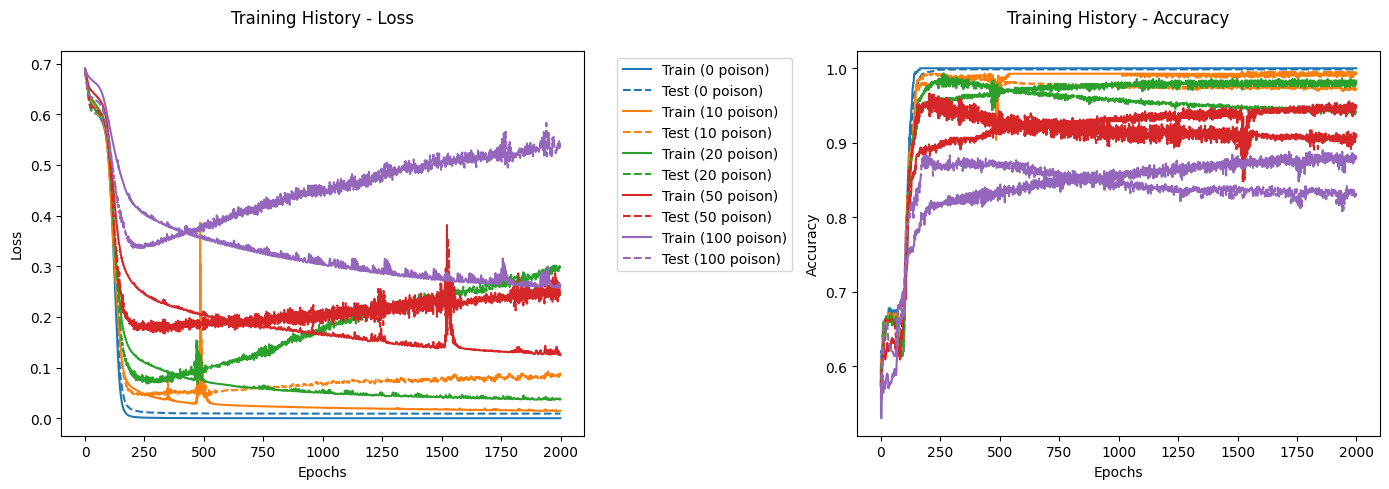

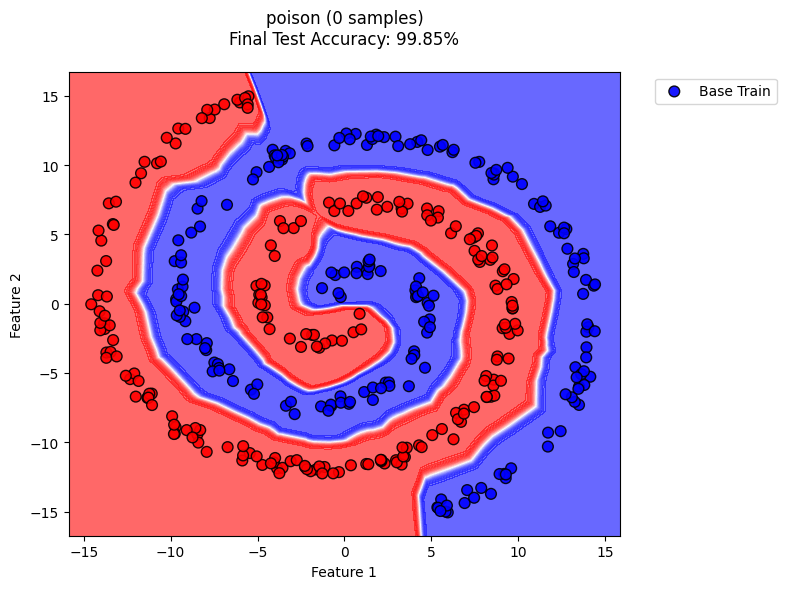

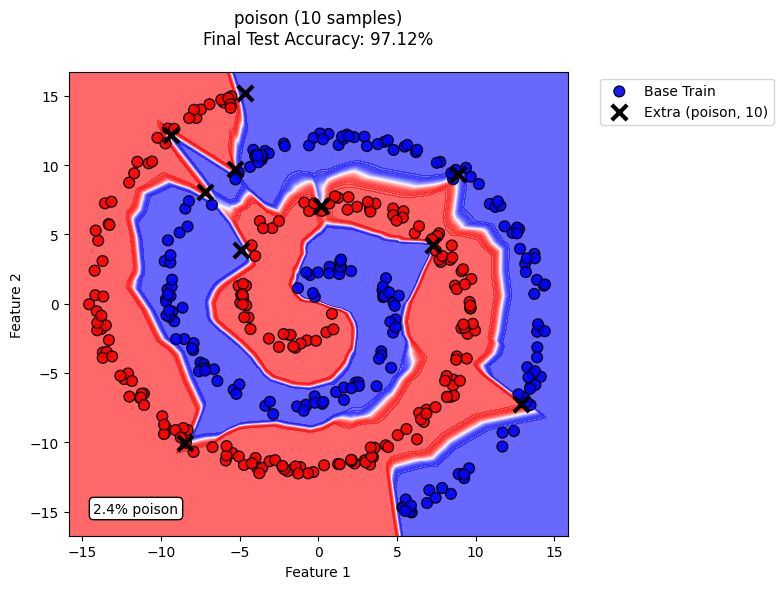

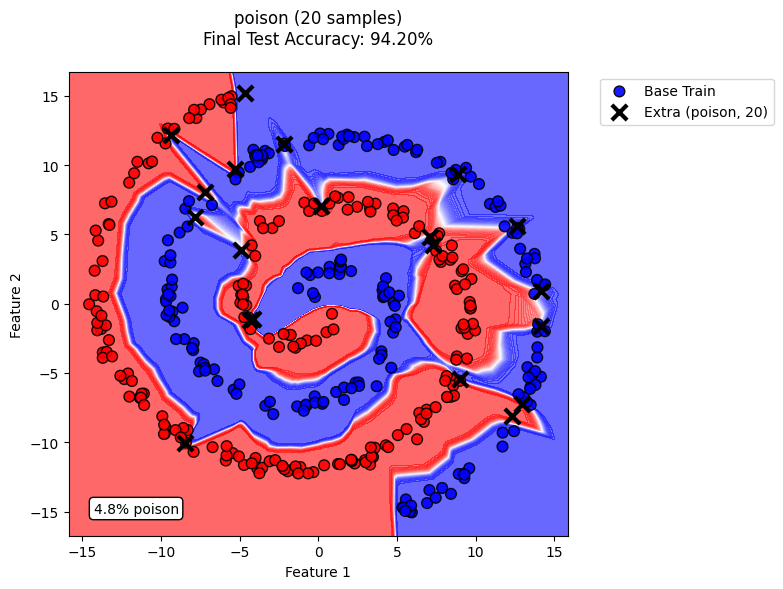

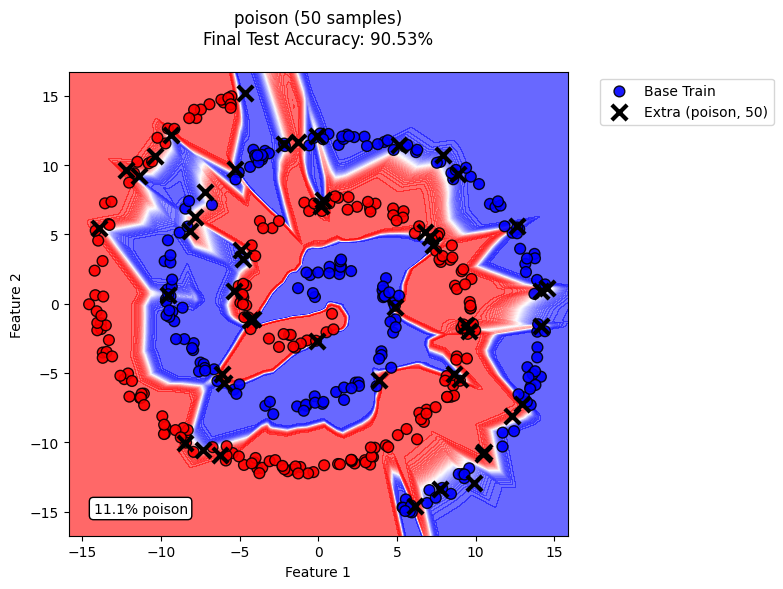

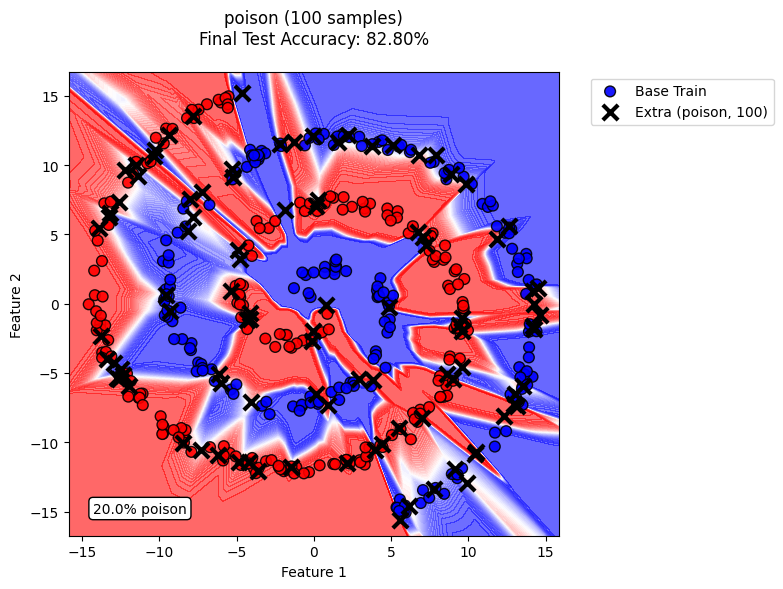

In [6]:
model_module.verify_model_results(
    all_models=all_models,
    x_base_train=x_base_train,
    y_base_train=y_base_train,
    x_additional=x_additional,
    y_additional=y_additional,
    x_test=x_test,
    y_test=y_test,
    dataset_quantities=dataset_quantities,
    dataset_type=dataset_type,
)

## Model Saving

In [7]:
# ====================================
# Save Datasets and Models
# ====================================
output_folder = "models_and_data"
# Save dataset (Possible to skip)
if save_generated_dataset:
    save_dataset(
        folder=output_folder,
        filename="dataset.pt",
        x_base_train=x_base_train,
        y_base_train=y_base_train,
        x_additional=x_additional,
        y_additional=y_additional,
        x_test=x_test,
        y_test=y_test,
        dataset_quantities=dataset_quantities,
        dataset_type=dataset_type,
    )
    print(f"Saved dataset to {output_folder}/dataset.pt")

# Save trained models
if save_generated_models:
    for model_data in all_models:
        filename = f"model_additional_{model_data['additional_data']}.pt"
        save_model(
            folder=output_folder,
            filename=filename,
            model=model_data["model"],
            train_loss=model_data["train_loss"],
            train_accs=model_data["train_accs"],
            test_loss=model_data["test_loss"],
            test_accs=model_data["test_accs"],
            additional_data=model_data["additional_data"],
            dataset_type=model_data["dataset_type"],
        )
        print(f"Saved model: {output_folder}/{filename}")

✅ Dataset saved to models_and_data\dataset.pt
Saved dataset to models_and_data/dataset.pt
✅ Model saved to models_and_data\model_additional_0.pt
Saved model: models_and_data/model_additional_0.pt
✅ Model saved to models_and_data\model_additional_10.pt
Saved model: models_and_data/model_additional_10.pt
✅ Model saved to models_and_data\model_additional_20.pt
Saved model: models_and_data/model_additional_20.pt
✅ Model saved to models_and_data\model_additional_50.pt
Saved model: models_and_data/model_additional_50.pt
✅ Model saved to models_and_data\model_additional_100.pt
Saved model: models_and_data/model_additional_100.pt
